In [1]:
from typing import Callable, Tuple
from IPython.core.display_functions import display
from sklearn.datasets import make_classification, make_moons
import numpy as np
from numpy import ndarray
import matplotlib.pyplot as plt
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_curve, RocCurveDisplay, auc, roc_auc_score, f1_score, balanced_accuracy_score
from time import time_ns, time
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder
plt.rcParams["figure.figsize"] = (20,10)
random_state = 244827
n_samples = 2427
n_trains = 1

## Klasa na dane

In [2]:
class PUMData:
    def __init__(self, gen, random_state=244827, test_size=0.2):
        self.x_train, self.x_test, self.y_train, self.y_test = train_test_split(gen[0], gen[1], test_size=test_size, random_state=random_state, shuffle=True, stratify=gen[1])
        self.big_x_train, self.small_x_train, self.big_y_train, self.small_y_train = train_test_split(self.x_train, self.y_train, test_size=0.035, random_state=random_state)

    def normalize(self, min_v=0, max_v=1):
        for i in range(self.x_train.shape[1]):
            x_min = np.min(self.x_train[:, i])
            x_max = np.max(self.x_train[:, i])
            if x_min != x_max:
                self.x_train[:, i] = (self.x_train[:, i] - x_min) / (x_max - x_min)
                self.x_train[:, i] = self.x_train[:, i] * (max_v - min_v) + min_v

                self.small_x_train[:, i] = (self.small_x_train[:, i] - x_min) / (x_max - x_min)
                self.small_x_train[:, i] = self.small_x_train[:, i] * (max_v - min_v) + min_v

                self.big_x_train[:, i] = (self.big_x_train[:, i] - x_min) / (x_max - x_min)
                self.big_x_train[:, i] = self.big_x_train[:, i] * (max_v - min_v) + min_v

                self.x_test[:, i] = (self.x_test[:, i] - x_min) / (x_max - x_min)
                self.x_test[:, i] = self.x_test[:, i] * (max_v - min_v) + min_v
            else:
                self.x_train[:, i] = 1
                self.x_test[:, i] = 1
                self.small_x_train[:, i] = 1
                self.big_x_train[:, i] = 1

    def change_labels(self, old: list, new: list):
        for o, n in zip(old, new):
            self.y_test[self.y_test == o] = n
            self.y_train[self.y_train == o] = n
            self.big_y_train[self.big_y_train == o] = n
            self.small_y_train[self.small_y_train == o] = n

    def winsorize(self):
        for i in range(self.x_train.shape[1]):
            if len(np.unique(self.x_train[:, i])) == 2:
                continue
            q1_train = np.percentile(self.x_train[:, i], 25)
            q3_train = np.percentile(self.x_train[:, i], 75)
            iqr_train = q3_train - q1_train
            self.x_train[:, i] = np.clip(self.x_train[:, i], q1_train - 1.5 * iqr_train, q3_train + 1.5 * iqr_train)

            q1_test = np.percentile(self.x_test[:, i], 25)
            q3_test = np.percentile(self.x_test[:, i], 75)
            iqr_test = q3_test - q1_test
            self.x_test[:, i] = np.clip(self.x_test[:, i], q1_test - 1.5 * iqr_test, q3_test + 1.5 * iqr_test)

    def make_polynomial(self, poly_degree=2, include_bias=False):
        self.x_test = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_test)
        self.x_train = PolynomialFeatures(degree=poly_degree, include_bias=include_bias).fit_transform(self.x_train)

## Klasa Drzewa decyzyjnego oraz pomocnicza klasa do struktury drzewa

In [3]:
class Node:
    def __init__(self, feature: int=None, threshold: float=None, left=None, right=None, prediction=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.prediction = prediction


class MyDecisionTree:
    _accepted_criterions = ['entropy', 'gini']
    def __init__(self, criterion: str= 'entropy', max_depth: int=99, min_samples_split: int=2, probing_splits: int = 20, n_train_feats=None, random_state=None):
        if criterion not in self._accepted_criterions:
            raise ValueError('Loss must be one of {}'.format(self._accepted_criterions))

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.probing_splits = probing_splits
        self.random_state = random_state
        self.root = None
        self.n_train_feats = n_train_feats
        self.criterion = {'entropy': self._entropy, 'gini': self._gini_index}[criterion]
        self.x_train = None

    @staticmethod
    def _gini_index(y: ndarray) -> float:
        unique_y = np.unique(y)
        gini = 0
        for cls in unique_y:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls ** 2
        return 1 - gini

    @staticmethod
    def _entropy(y: ndarray) -> float:
        unique_y = np.unique(y)
        entropy = 0
        for cls in unique_y:
            p_cls = len(y[y == cls]) / len(y)
            entropy += -p_cls * np.log2(p_cls)
        return entropy


    def _build_tree(self, x_train: ndarray, y_train: ndarray, depth: int = 0) -> Node:
        n, m = x_train.shape
        n_labels = len(np.unique(y_train))

        if depth >= self.max_depth or n_labels == 1 or n < self.min_samples_split:
            value = np.argmax(np.bincount(y_train))
            return Node(prediction=value)

        best_feature, best_threshold = self._best_split(x_train, y_train)

        if best_feature is None:
            value = np.argmax(np.bincount(y_train))
            return Node(prediction=value)

        left = self._build_tree(x_train[x_train[:, best_feature] <= best_threshold], y_train[x_train[:, best_feature] <= best_threshold], depth + 1)
        right = self._build_tree(x_train[x_train[:, best_feature] > best_threshold], y_train[x_train[:, best_feature] > best_threshold], depth + 1)
        return Node(feature=best_feature, threshold=best_threshold, left=left, right=right)


    def _best_split(self, x_train: ndarray, y: ndarray) -> (int, float):
        best_gain = -float('inf')
        best_feature = None
        best_threshold = None

        if self.n_train_feats is None:
            feats = range(x_train.shape[1])
        elif self.n_train_feats == int(self.n_train_feats):
            feats = np.random.choice(range(x_train.shape[1]), self.n_train_feats, replace=False)
        elif 1 > self.n_train_feats > 0:
            feats = np.random.choice(range(x_train.shape[1]), int(self.n_train_feats * x_train.shape[1]), replace=False)
        else:
            raise ValueError('n_train_feats must be int or float between 0 and 1 or None')

        for feat in feats:
            feat_col = x_train[:, feat]
            thrs = np.unique(feat_col)
            if len(thrs) > self.probing_splits:
                resolution = (x_train.max() - x_train.min()) / self.probing_splits
                thrs = np.arange(np.min(x_train) + resolution, np.max(x_train) - resolution, resolution)
            for threshold in thrs:
                info_gain = self._info_gain(feat_col, y, threshold)

                if info_gain > best_gain:
                    best_gain = info_gain
                    best_feature = feat
                    best_threshold = threshold

        if best_gain == 0:
            return None, None

        return best_feature, best_threshold


    def _info_gain(self, x: ndarray, y: ndarray, threshold: float) -> float:
        org_entropy = self.criterion(y)
        left_idx = np.argwhere(x <= threshold).flatten()
        right_idx = np.argwhere(x > threshold).flatten()

        if len(left_idx) == 0 or len(right_idx) == 0:
            return 0

        n = y.shape[0]
        left_entropy = self.criterion(y[left_idx])
        right_entropy = self.criterion(y[right_idx])
        split_entropy = (len(left_idx) / n) * left_entropy + (len(right_idx) / n) * right_entropy

        return org_entropy - split_entropy

    def _walk_tree(self, node: Node, x: ndarray) -> int:
        if node.prediction is not None:
            return node.prediction

        if x[node.feature] <= node.threshold:
            return self._walk_tree(node.left, x)
        else:
            return self._walk_tree(node.right, x)

    def fit(self, x_train: ndarray, y_train: ndarray):
        self.x_train = x_train
        self.root = self._build_tree(x_train, y_train)
        return self

    def predict(self, x: ndarray) -> ndarray:
        if self.root is None:
            raise ValueError('Tree not fitted')

        return np.array([self._walk_tree(self.root, x_sample) for x_sample in x])

class MyRandomForest:
    def __init__(self, n_estimators: int = 100, criterion: str = 'gini', min_samples_split: int=2, max_depth: int=99, probing_splits: int=20, n_jobs: int=1, n_feats_train: int=None):
        self.n_estimators = n_estimators
        self.criterion = criterion
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.probing_splits = probing_splits
        self.n_train_feats = n_feats_train
        self.n_jobs = n_jobs
        self.estimators = []

    @staticmethod
    def _train_sample(x_train: ndarray, y_train: ndarray) -> (ndarray, ndarray):
        sample_idx = np.random.choice(x_train.shape[0], x_train.shape[0], replace=False)
        return x_train[sample_idx], y_train[sample_idx]

    def fit(self, x_train: ndarray, y_train: ndarray):
        self.estimators = [MyDecisionTree(criterion=self.criterion, min_samples_split=self.min_samples_split, max_depth=self.max_depth, probing_splits=self.probing_splits, n_train_feats=self.n_train_feats) for _ in range(self.n_estimators)]
        for estimator in self.estimators:
            x_sample, y_sample = self._train_sample(x_train, y_train)
            estimator.fit(x_sample, y_sample)

    def predict(self, x: ndarray) -> ndarray:
        if len(self.estimators) == 0:
            raise ValueError('Tree not fitted')

        preds = np.array([estimator.predict(x) for estimator in self.estimators]).T
        return np.array([np.argmax(np.bincount(pred)) for pred in preds])

## Funkcja do porównywania modeli

In [4]:
def compare_models(my_model, sk_model, data: PUMData):
    x_min, x_max = data.x_test[:, 0].min() - 0.25, data.x_test[:, 0].max() + 0.25
    y_min, y_max = data.x_test[:, 1].min() - 0.25, data.x_test[:, 1].max() + 0.25
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    mesh_data = np.c_[xx.ravel(), yy.ravel()]

    Z_an = my_model.predict(mesh_data).reshape(xx.shape)
    Z_sk = sk_model.predict(mesh_data).reshape(xx.shape)

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(20, 15))

    for idx, Z, title in zip(
        range(2),
        [Z_an, Z_sk],
        ['Implementacja własna', 'Model DecisionTreeClassifier']):
        axarr[idx].contourf(xx, yy, Z, alpha=0.4, levels=1)
        axarr[idx].scatter(data.x_test[:, 0], data.x_test[:, 1], c=data.y_test, s=20, edgecolor="k")
        axarr[idx].set_title(title)

    plt.show()

    y_an_predicted = my_model.predict(data.x_test)
    y_sk_predicted = sk_model.predict(data.x_test)

    cm_sk = confusion_matrix(data.y_test, y_sk_predicted, labels=[0, 1])
    cm_an = confusion_matrix(data.y_test, y_an_predicted, labels=[0, 1])

    sensitivity_sk = cm_sk[1, 1] / (cm_sk[1, 0] + cm_sk[1, 1])
    specifity_sk = cm_sk[0, 0] / (cm_sk[0, 0] + cm_sk[0, 1])

    sensitivity_an = cm_an[1, 1] / (cm_an[1, 0] + cm_an[1, 1])
    specifity_an = cm_an[0, 0] / (cm_an[0, 0] + cm_an[0, 1])

    print(f'Model własny: Czulość: {sensitivity_an}, swoistość: {specifity_an}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_an_predicted, adjusted=True)}')
    print(f'Model sklearn: Czulość: {sensitivity_sk}, swoistość: {specifity_sk}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_sk_predicted, adjusted=True)}')

    f, axarr = plt.subplots(1, 2, sharex="col", sharey="row", figsize=(15, 8))

    for idx, cm, title in zip(
        range(2),
        [cm_an, cm_sk],
        ['Implementacja własna', 'Model DecisionTreeClassifier']
    ):
        sns.heatmap(cm, annot=True, fmt="d", ax=axarr[idx], cmap="Blues")
        axarr[idx].set_title(title)

    plt.show()

## Generacja danych

In [5]:
single_mod_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=1, random_state=random_state), random_state=random_state)

In [6]:
dual_mod_data = PUMData(make_classification(n_samples=n_samples, n_features=2, n_redundant=0, n_classes=2, n_clusters_per_class=2, random_state=random_state), random_state=random_state)

## Trening na danych jednomodowych z nieograniczoną (teoretycznie) głębokością drzewa

In [7]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini')
    my_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 22.1166512966156


In [8]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini')
    sk_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.00247955322265625


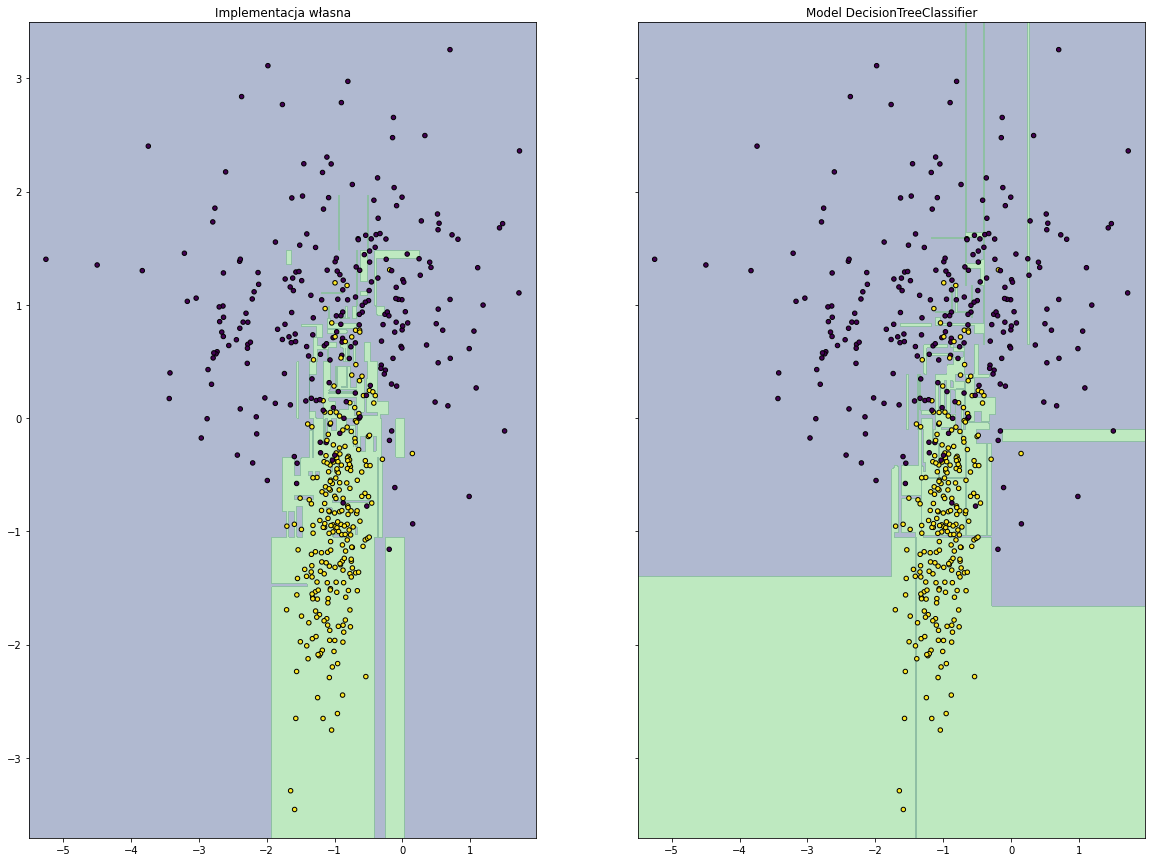

Model własny: Czulość: 0.8770491803278688, swoistość: 0.8925619834710744, Adjusted accuracy=0.7696111637989431
Model sklearn: Czulość: 0.8770491803278688, swoistość: 0.8760330578512396, Adjusted accuracy=0.7530822381791085


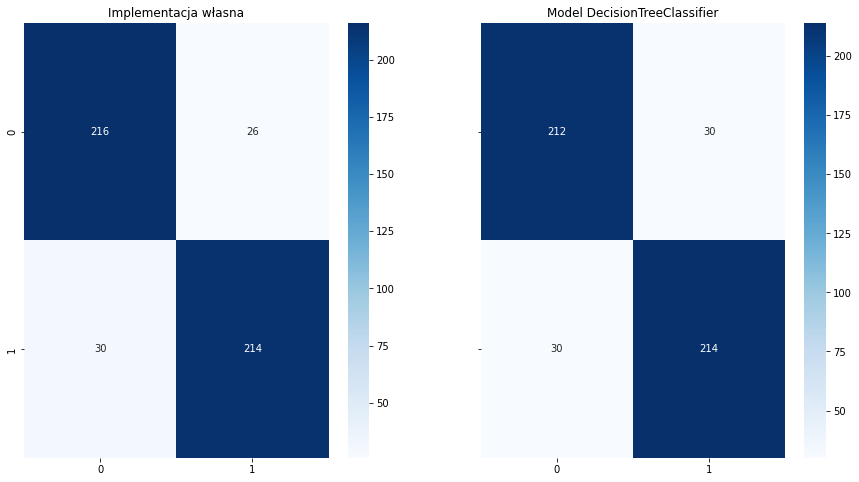

In [9]:
compare_models(my_model, sk_model, single_mod_data)

## Trening na danych dwumodowych z nieograniczoną (teoretycznie) głębokością drzewa

In [10]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini')
    my_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.23361539840698242


In [11]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini')
    sk_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.0024797916412353516


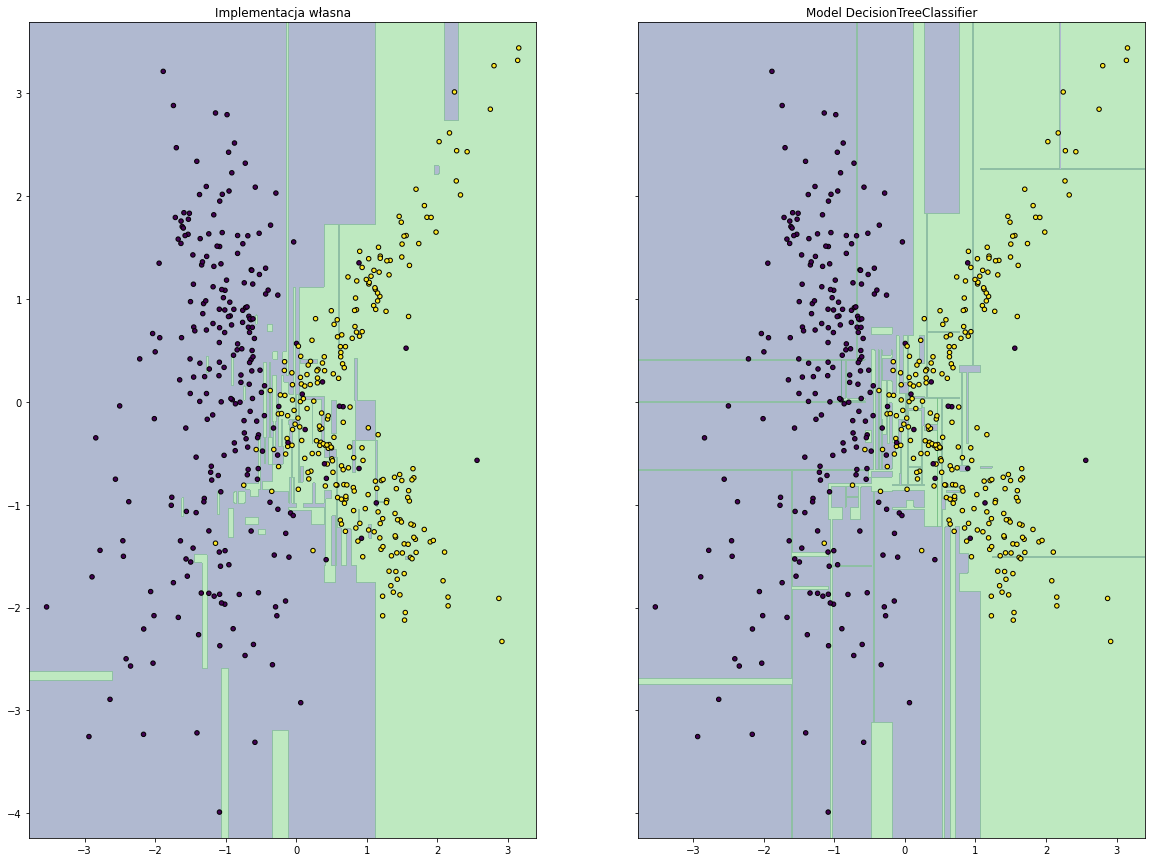

Model własny: Czulość: 0.8934426229508197, swoistość: 0.9297520661157025, Adjusted accuracy=0.823194689066522
Model sklearn: Czulość: 0.9139344262295082, swoistość: 0.8966942148760331, Adjusted accuracy=0.8106286411055412


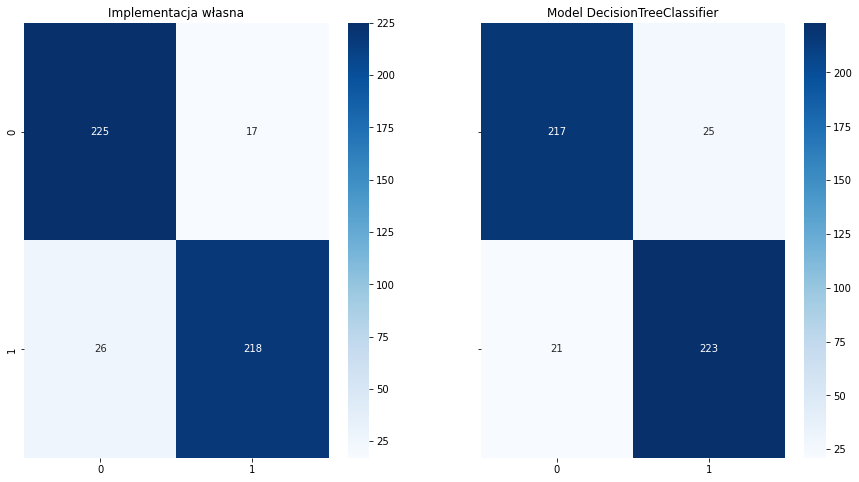

In [12]:
compare_models(my_model, sk_model, dual_mod_data)

## Trening na danych jednomodowych z ograniczoną do ilości cech głębokością drzewa

In [13]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini', max_depth=single_mod_data.x_train.shape[1])
    my_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.0099334716796875


In [14]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini', max_depth=single_mod_data.x_train.shape[1])
    sk_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.0009920597076416016


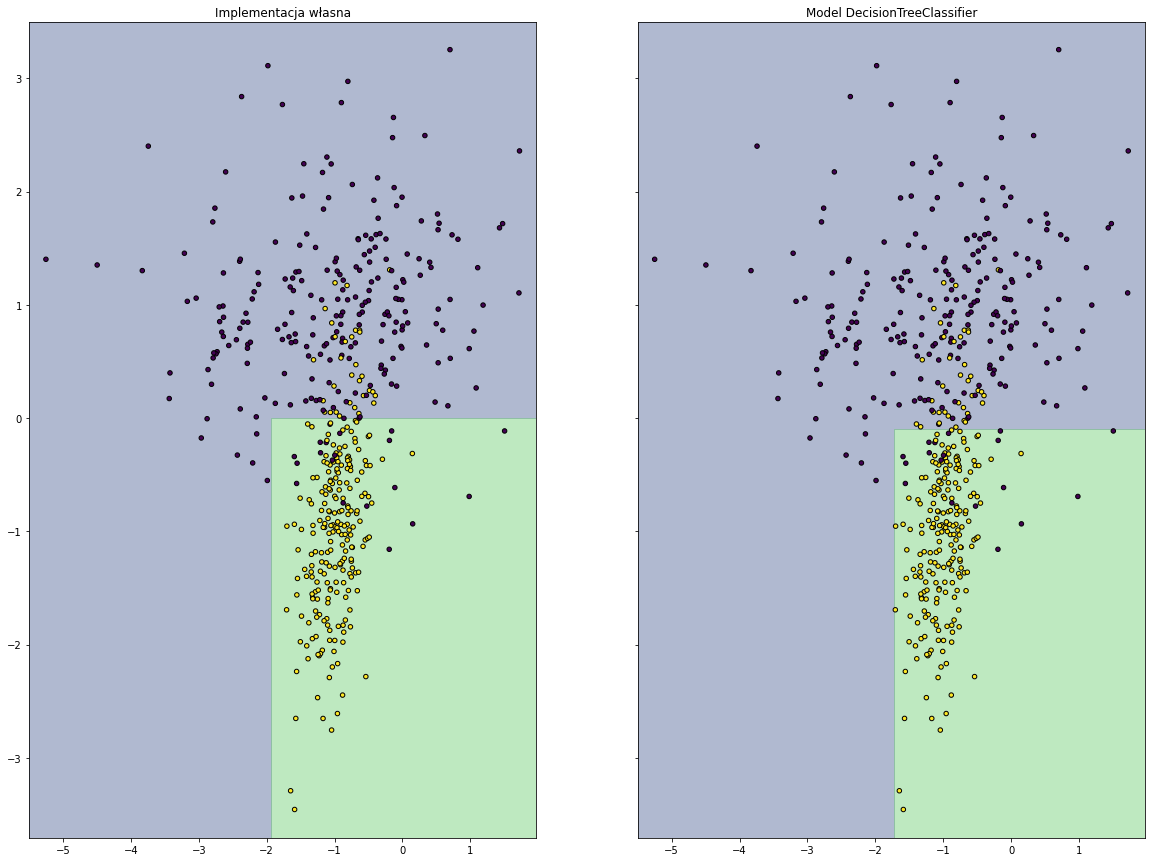

Model własny: Czulość: 0.8729508196721312, swoistość: 0.9132231404958677, Adjusted accuracy=0.7861739601679989
Model sklearn: Czulość: 0.8483606557377049, swoistość: 0.9256198347107438, Adjusted accuracy=0.7739804904484489


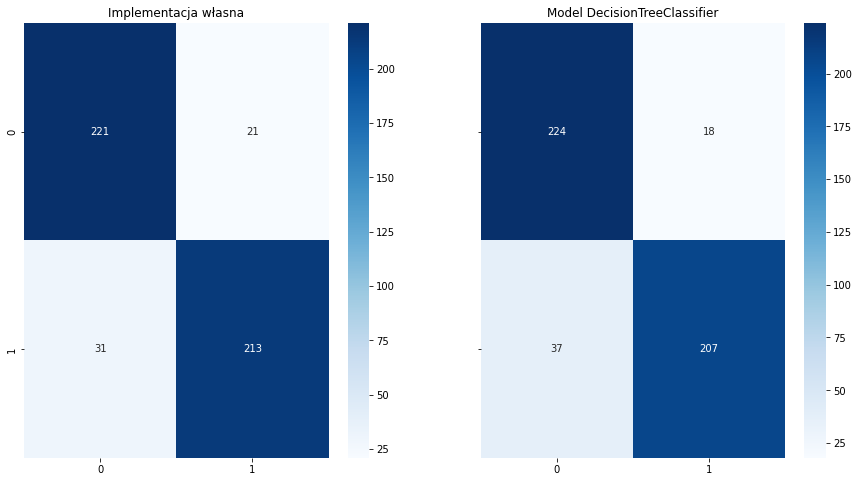

In [15]:
compare_models(my_model, sk_model, single_mod_data)

## Trening na danych wielomodowych z ograniczoną do ilości cech głębokością drzewa

In [16]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini', max_depth=single_mod_data.x_train.shape[1])
    my_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.010415792465209961


In [17]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini', max_depth=single_mod_data.x_train.shape[1])
    sk_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.0009918212890625


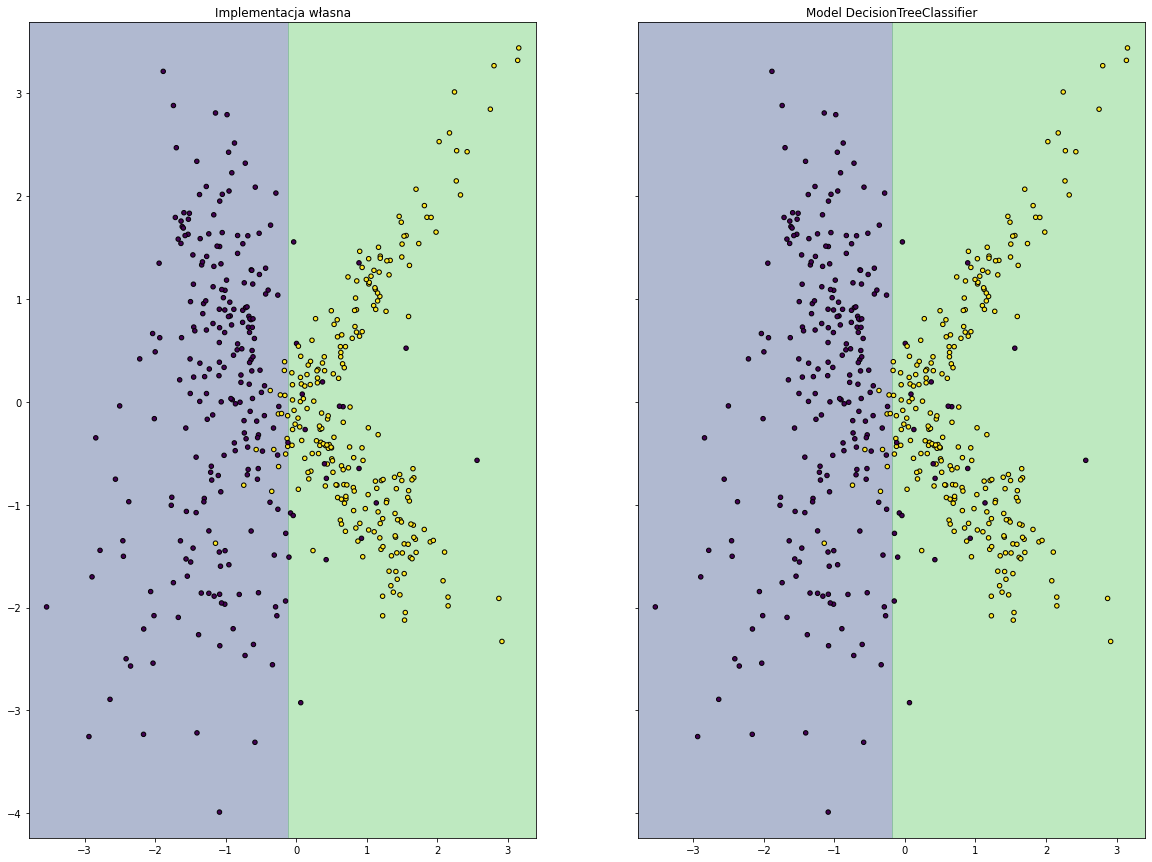

Model własny: Czulość: 0.930327868852459, swoistość: 0.9173553719008265, Adjusted accuracy=0.8476832407532855
Model sklearn: Czulość: 0.9590163934426229, swoistość: 0.9049586776859504, Adjusted accuracy=0.8639750711285732


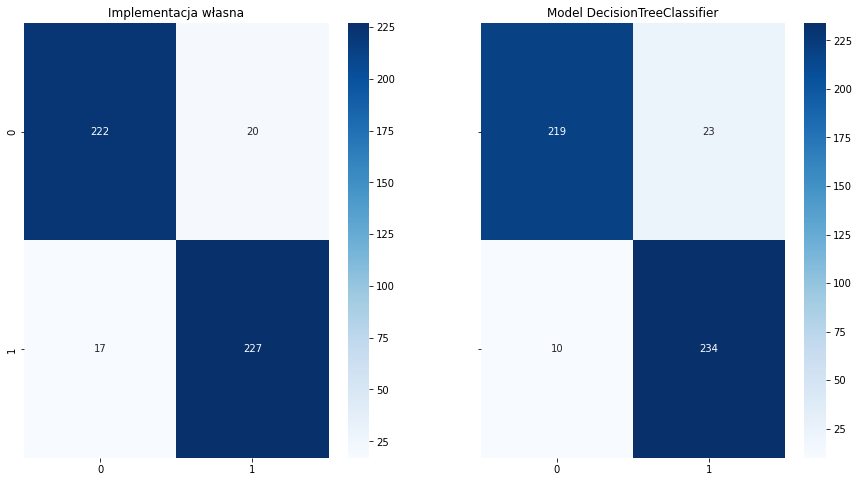

In [18]:
compare_models(my_model, sk_model, dual_mod_data)

## Trening na danych jednomodowych z ograniczoną do ilości klastrów głębokością drzewa

In [19]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini', max_depth=2)
    my_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.009933233261108398


In [20]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini', max_depth=2)
    sk_model.fit(single_mod_data.x_train, single_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.0009913444519042969


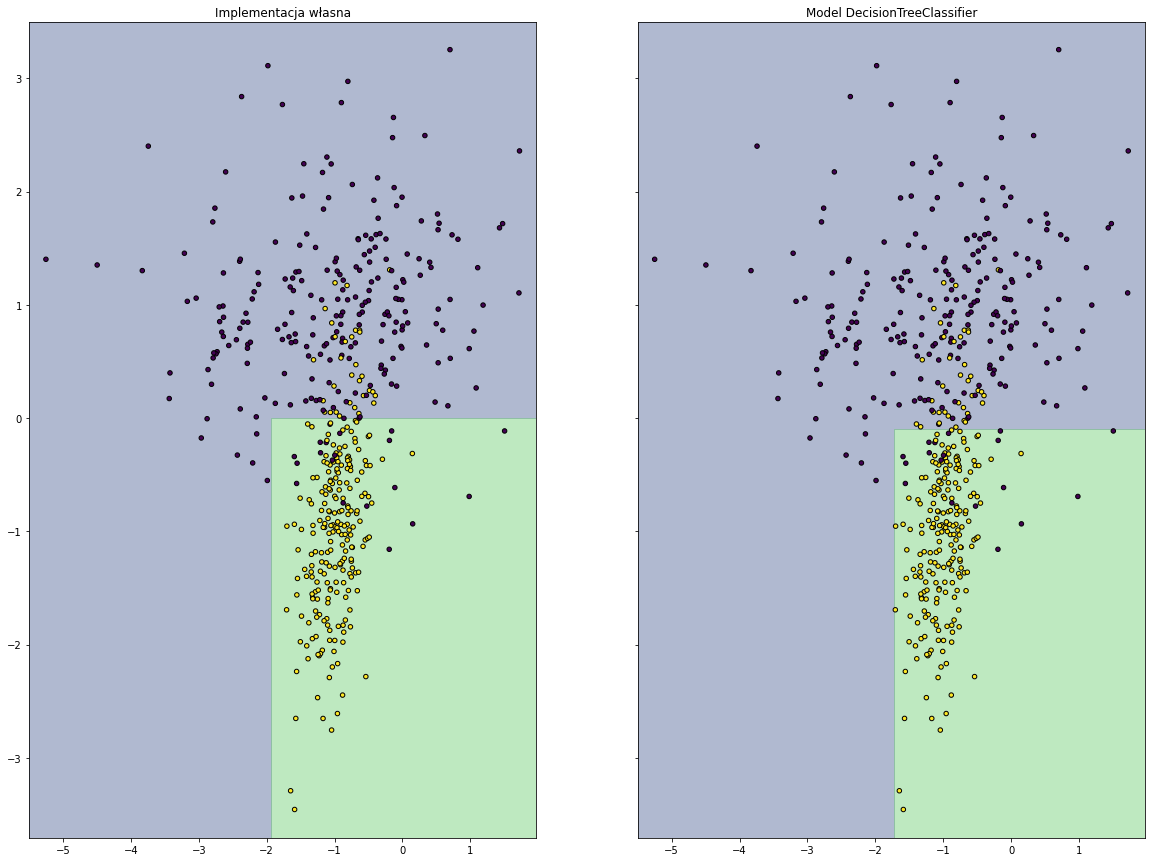

Model własny: Czulość: 0.8729508196721312, swoistość: 0.9132231404958677, Adjusted accuracy=0.7861739601679989
Model sklearn: Czulość: 0.8483606557377049, swoistość: 0.9256198347107438, Adjusted accuracy=0.7739804904484489


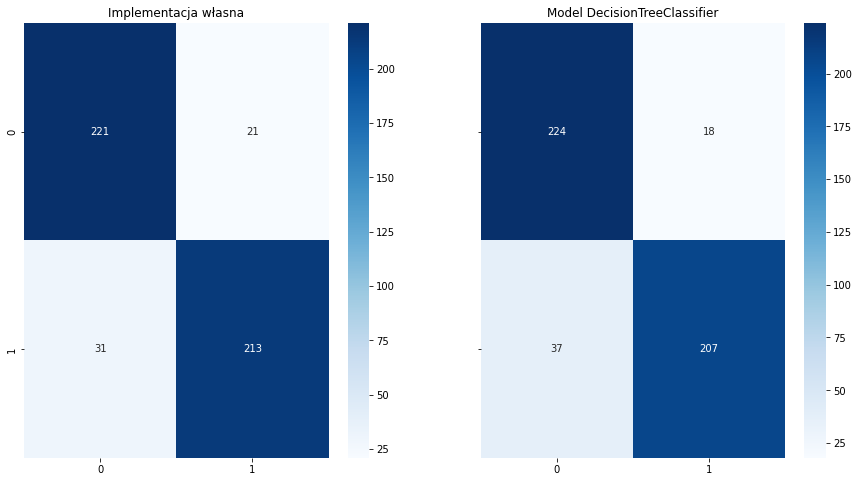

In [21]:
compare_models(my_model, sk_model, single_mod_data)

## Trening na danych wielomodowych z ograniczoną do ilości klastrów głębokością drzewa

In [22]:
start = time()
for _ in range(n_trains):
    my_model = MyRandomForest(criterion='gini', max_depth=4)
    my_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.03123307228088379


In [23]:
start = time()
for _ in range(n_trains):
    sk_model = RandomForestClassifier(criterion='gini', max_depth=4)
    sk_model.fit(dual_mod_data.x_train, dual_mod_data.y_train)
print(f'Average time for {n_trains} trains: {(time() - start) / n_trains}')

Average time for 1 trains: 0.0014884471893310547


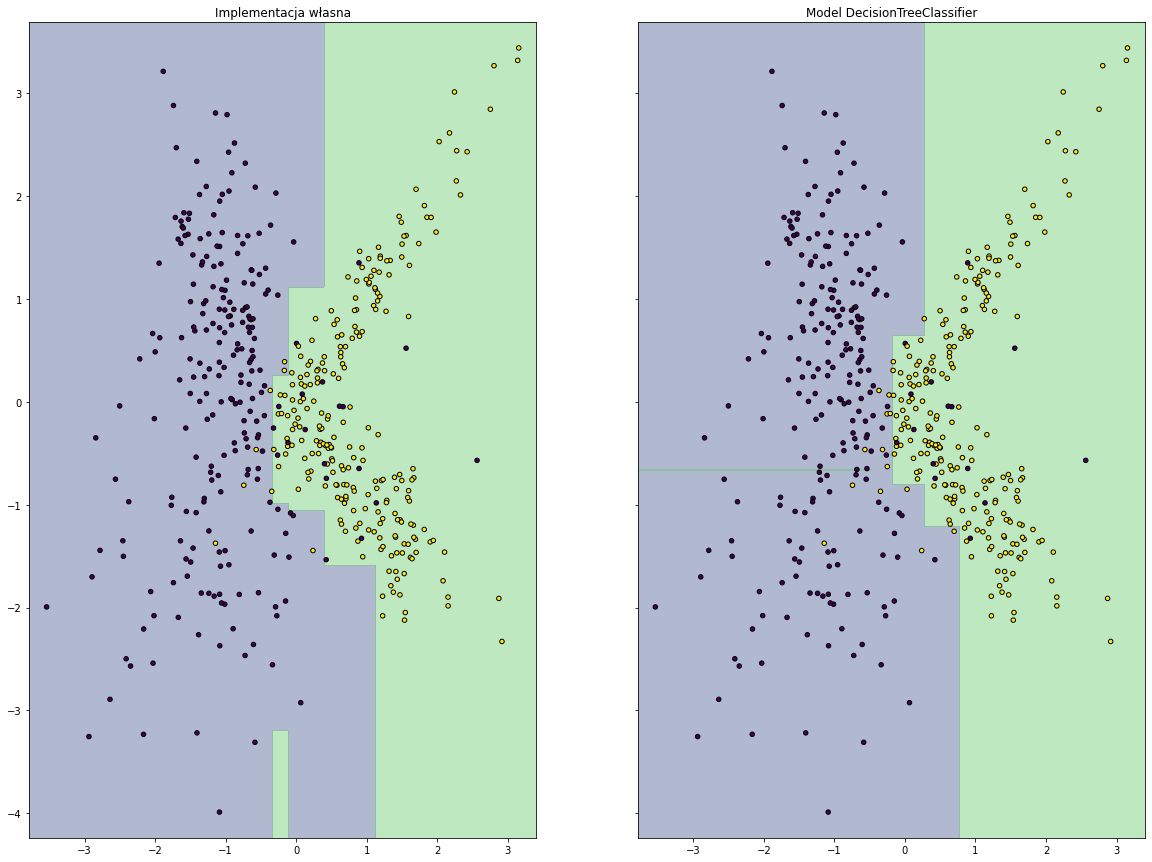

Model własny: Czulość: 0.9672131147540983, swoistość: 0.9214876033057852, Adjusted accuracy=0.8887007180598836
Model sklearn: Czulość: 0.9426229508196722, swoistość: 0.9380165289256198, Adjusted accuracy=0.8806394797452919


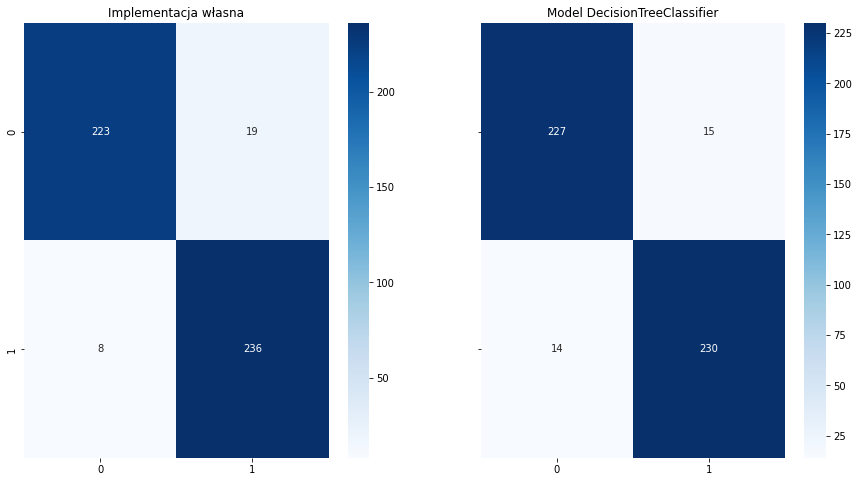

In [24]:
compare_models(my_model, sk_model, dual_mod_data)

# Czesc na 4

In [25]:
raw_htru = np.genfromtxt('HTRU_2.csv', delimiter=',')

OSError: HTRU_2.csv not found.

In [ ]:
htru_data = PUMData((raw_htru[:, :-1], raw_htru[:, -1].astype(int)), random_state=random_state)
htru_data.winsorize()
htru_data.normalize()

In [ ]:
params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'min_samples_split': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
    'min_samples_leaf': [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20],
}

tree = DecisionTreeClassifier(random_state=random_state)
grid_searcher = GridSearchCV(tree, params, scoring='balanced_accuracy', n_jobs=8)

In [ ]:
start = time()
grid_searcher.fit(htru_data.x_train, htru_data.y_train)
print(f'GridSearchCV searching time = {(time() - start) / 60} min')

In [ ]:
print(grid_searcher.best_params_)

In [ ]:
best_model = grid_searcher.best_estimator_

In [ ]:
def evaluate_mulit_feature_model(model, data, cm_labels=[0, 1]):
    y_predicted = model.predict(data.x_test)

    cm = confusion_matrix(data.y_test, y_predicted, labels=cm_labels)

    sensitivity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
    specifity = cm[0, 0] / (cm[0, 0] + cm[0, 1])

    print(f'Metryki modelu: Czulość: {sensitivity}, swoistość: {specifity}, Adjusted accuracy={balanced_accuracy_score(data.y_test, y_predicted, adjusted=True)}')

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title('Macierz pomyłek')
    plt.show()

    # decision_fun = model.decision_function(data.x_test)
    #
    # fpr, tpr, thresholds = roc_curve(data.y_test, decision_fun)
    # plt.plot(fpr, tpr, label=f'my model, AUC={roc_auc_score(data.y_test, decision_fun):.3f}')
    # plt.legend()
    # plt.show()

In [ ]:
evaluate_mulit_feature_model(best_model, htru_data)

In [ ]:
depths = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

In [ ]:
sk_learn_times = []
my_learn_times = []
sk_predict_times = []
my_predict_times = []
sk_accuracies = []
my_accuracies = []

In [ ]:
for depth in range(2, 21, 2):
    print(f'Depth: {depth}')
    start = time()
    for _ in range(10):
        my_model = MyDecisionTree(random_state=random_state, max_depth=depth)
        my_model.fit(htru_data.x_train, htru_data.y_train)
    my_learn_times.append((time() - start) / 10)

    start = time()
    for _ in range(10):
        sk_model = DecisionTreeClassifier(criterion='entropy', max_depth=depth)
        sk_model.fit(htru_data.x_train, htru_data.y_train)
    sk_learn_times.append((time() - start) / 10)

    start = time()
    for _ in range(10):
        my_predicts = my_model.predict(htru_data.x_test)
    my_predict_times.append((time() - start) / 10)

    start = time()
    for _ in range(10):
        sk_predicts = sk_model.predict(htru_data.x_test)
    sk_predict_times.append((time() - start) / 10)

    sk_accuracies.append(balanced_accuracy_score(htru_data.y_test, sk_predicts, adjusted=True))
    my_accuracies.append(balanced_accuracy_score(htru_data.y_test, my_predicts, adjusted=True))



In [ ]:
plt.plot(depths, sk_learn_times, label='scikit-learn')
plt.plot(depths, my_learn_times, label='my model')
plt.legend()
plt.title('Czas uczenia w zależności od głębokości drzewa')
plt.xlabel('Głębokość drzewa')
plt.ylabel('Czas uczenia (s)')
plt.xticks(depths)
plt.show()

In [ ]:
plt.plot(depths, sk_predict_times, label='scikit-learn')
plt.plot(depths, my_predict_times, label='my model')
plt.legend()
plt.title('Czas predykcji w zależności od głębokości drzewa')
plt.xlabel('Głębokość drzewa')
plt.ylabel('Czas predykcji (s)')
plt.xticks(depths)
plt.show()

In [ ]:
plt.plot(depths, sk_accuracies, label='scikit-learn')
plt.plot(depths, my_accuracies, label='my model')
plt.legend()
plt.title('Balanced accuracy w zależności od głębokości drzewa')
plt.xlabel('Głębokość drzewa')
plt.ylabel('Balanced accuracy')
plt.xticks(depths)
plt.show()